In [149]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from FastCCM import CCM
from manifold_learning.utils import utils
from manifold_learning.data.data_loader import load_co2_dataset
from manifold_learning import imd_nd_smap, imd_1d_smap
from scipy.ndimage import distance_transform_edt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

In [3]:
data = load_co2_dataset()

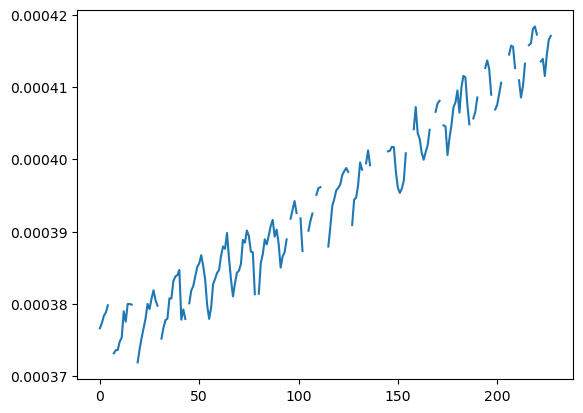

In [4]:
plt.plot(data[:,25,20])

In [64]:

def interpolate_nans(data):
    # Create the grid
    time = np.arange(data.shape[0])
    x = np.arange(data.shape[1])
    y = np.arange(data.shape[2])

    # Create a meshgrid for the coordinates
    time_grid, x_grid, y_grid = np.meshgrid(time, x, y, indexing='ij')

    # Mask array to identify NaNs
    mask = np.isnan(data)
    
    # Initial nearest-neighbor interpolation using distance transform
    data_filled = data.copy()
    distances, indices = distance_transform_edt(mask, return_indices=True)
    data_filled[mask] = data[tuple(indices)][mask]

    # Function to perform linear interpolation
    def linear_interpolate(data):
        coords = np.array(np.nonzero(np.isnan(data)))
        values = data[~np.isnan(data)]
        filled_values = griddata(
            np.array(np.nonzero(~np.isnan(data))).T,
            values,
            coords.T,
            method='linear'
        )
        data[coords[0], coords[1], coords[2]] = filled_values
        return data

    # Iteratively refine the interpolation
    while np.any(np.isnan(data_filled)):
        data_filled = linear_interpolate(data_filled)

    return data_filled

interpolated_data = interpolate_nans(data)

In [65]:

interpolated_data_ma = pd.DataFrame(interpolated_data.reshape(-1,36*72)).rolling(window=30,min_periods=1).mean().to_numpy()
interpolated_data_ma = interpolated_data_ma[15:]
#interpolated_data = interpolated_data.reshape(-1,36*72)[:-15]
X =  interpolated_data.reshape(-1,36*72)[:-15] - interpolated_data_ma

In [66]:
mask = plt.np.isnan(data.reshape(-1,36*72)).sum(axis=0)<70
filtered_data = interpolated_data.reshape(-1,36*72)[:,mask]

In [67]:
filtered_data_ma = pd.DataFrame(filtered_data).rolling(window=30,min_periods=1).mean().to_numpy()
filtered_data_ma = filtered_data_ma[15:]
filtered_data = filtered_data[:-15]


In [68]:
X = filtered_data - filtered_data_ma

In [69]:
mask.sum()

237

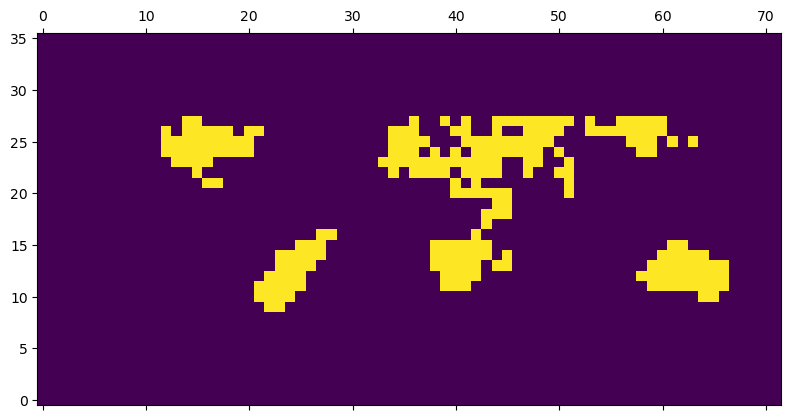

In [10]:
plt.matshow(mask.reshape(36,72),origin="lower")

/tmp/ipykernel_304069/3106342159.py:1: RuntimeWarning: Mean of empty slice
  plt.matshow(np.nanmean(data,axis=0),origin="lower")


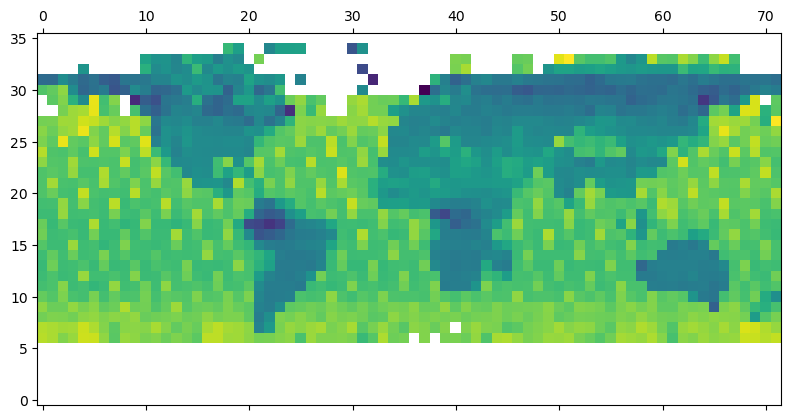

In [11]:
plt.matshow(np.nanmean(data,axis=0),origin="lower")

In [12]:
ccm = CCM.PairwiseCCM(device="cuda")

In [52]:
# Find optimal E and tau

E_range = np.arange(1,7)
tau_range = np.arange(1,10,1)
tp_max = 10

optimal_tau = []
optimal_E = []
value = []

for id in range(X.shape[1]):
    X_emb = np.concatenate([np.array([utils.get_td_embedding_np(X[:-tp_max,[id]],e,tau)[:,:,0] for e in E_range],dtype=object) for tau in tau_range])
    Y_emb = np.array([X[:,id][:i, None] for i in range(-(tp_max),-1)],dtype=object)
    res = ccm.compute(X_emb,Y_emb,subset_size=500,subsample_size=150,exclusion_rad=10,tp=0,subtract_corr=False,method="simplex",nbrs_num=10)[0].mean(axis=0).reshape(tau_range.shape[0],E_range.shape[0],)
    
    optimal_tau += [tau_range[np.unravel_index(np.argmax(res), res.shape)[0]]]
    optimal_E += [E_range[np.unravel_index(np.argmax(res), res.shape)[1]]]
    value  += [np.max(res)]
    print(id)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

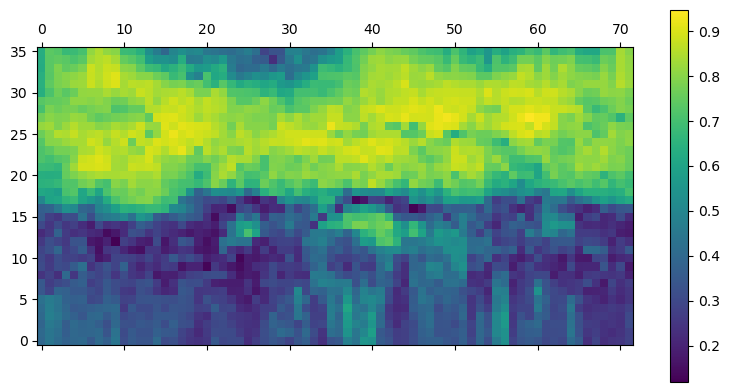

In [62]:

plt.matshow(np.array(value).reshape(36,72),origin="lower")
plt.colorbar()

In [79]:

observables = StandardScaler().fit_transform(X)

In [268]:
trainer = imd_nd_smap.IMD_nD_smap(observables.shape[1], embed_dim=2, n_components=10, subtract_corr=True, device="cuda")


In [269]:
trainer.fit(observables, sample_len=150, library_len=500, 
            exclusion_rad=5, theta=5, tp=10, 
            epochs=500, num_batches=32, optimizer="Adam", learning_rate=0.01, tp_policy="range")


Epoch 1/500, Loss: 1.2013
Epoch 2/500, Loss: 1.4837
Epoch 3/500, Loss: 1.4886
Epoch 4/500, Loss: 1.4683
Epoch 5/500, Loss: 1.4413
Epoch 6/500, Loss: 1.3945
Epoch 7/500, Loss: 1.3591
Epoch 8/500, Loss: 1.3530
Epoch 9/500, Loss: 1.3391
Epoch 10/500, Loss: 1.3133
Epoch 11/500, Loss: 1.2993
Epoch 12/500, Loss: 1.2842
Epoch 13/500, Loss: 1.2711
Epoch 14/500, Loss: 1.2515
Epoch 15/500, Loss: 1.2382
Epoch 16/500, Loss: 1.2214
Epoch 17/500, Loss: 1.1964
Epoch 18/500, Loss: 1.2098
Epoch 19/500, Loss: 1.1961
Epoch 20/500, Loss: 1.1781
Epoch 21/500, Loss: 1.1858
Epoch 22/500, Loss: 1.1651
Epoch 23/500, Loss: 1.1549
Epoch 24/500, Loss: 1.1405
Epoch 25/500, Loss: 1.1274
Epoch 26/500, Loss: 1.1155
Epoch 27/500, Loss: 1.1115
Epoch 28/500, Loss: 1.1052
Epoch 29/500, Loss: 1.0990
Epoch 30/500, Loss: 1.0976
Epoch 31/500, Loss: 1.0923
Epoch 32/500, Loss: 1.0902
Epoch 33/500, Loss: 1.0886
Epoch 34/500, Loss: 1.0743
Epoch 35/500, Loss: 1.0721
Epoch 36/500, Loss: 1.0646
Epoch 37/500, Loss: 1.0573
Epoch 38/5

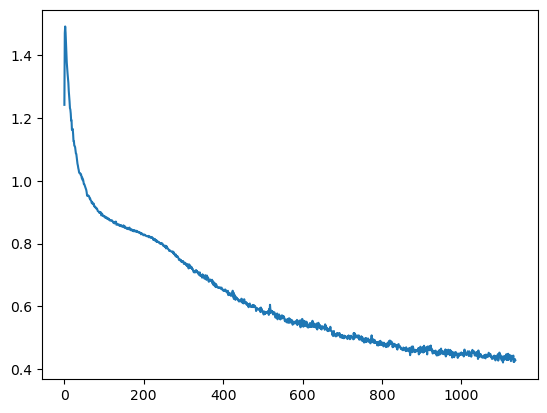

In [266]:
plt.plot(trainer.get_loss_history()[:])


In [258]:

unmixed = trainer.predict(observables)

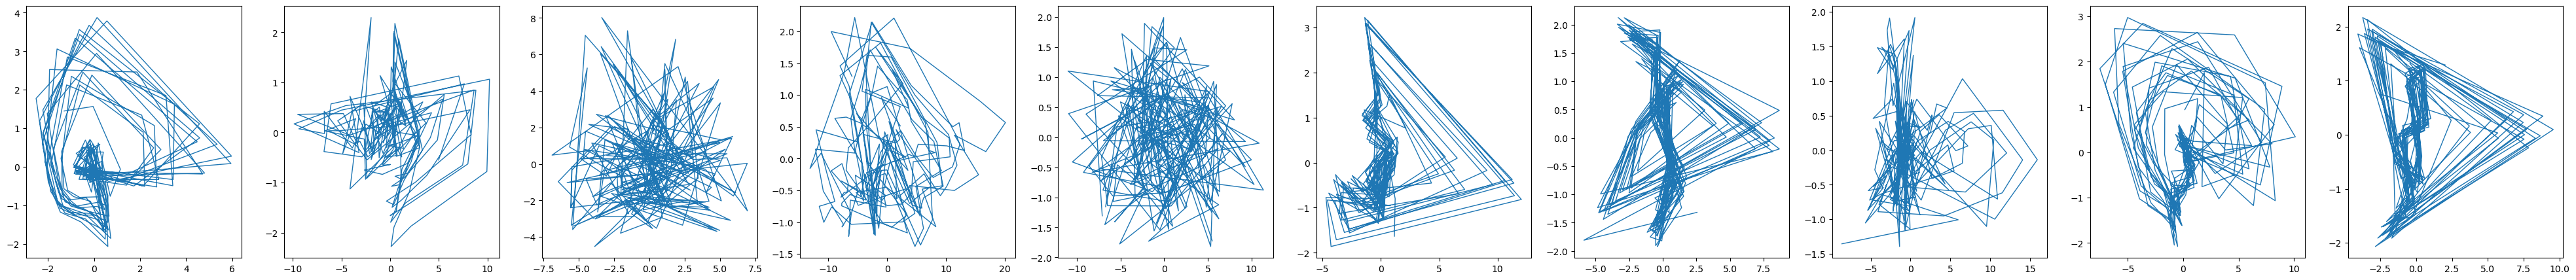

In [259]:
plt.figure(figsize=(5*unmixed.shape[1],5))
for i in range(unmixed.shape[1]):
    plt.subplot(1,unmixed.shape[1],i+1)
    x_pca = PCA(2).fit_transform(unmixed[:,i,:])
    plt.plot(x_pca[:,0],x_pca[:,1],linewidth=1)

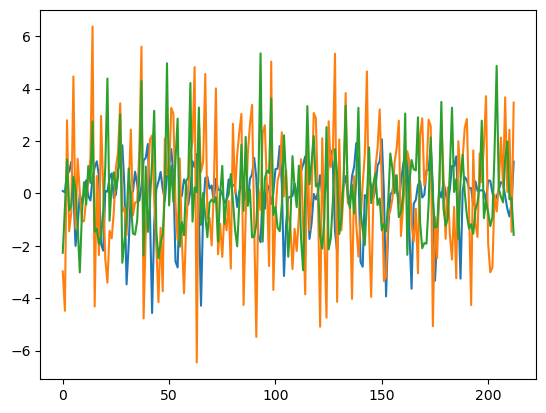

In [260]:

plt.plot(unmixed[:,0,1])
plt.plot(unmixed[:,4,1])
plt.plot(unmixed[:,2,1])

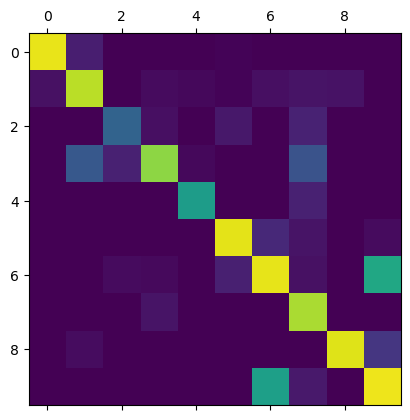

In [267]:
plt.matshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),np.transpose(unmixed,axes=(1,0,2)),500,500,60,5,method="smap",theta=5,).mean(axis=0),vmin=0,vmax=1)

In [262]:
np.transpose(unmixed,axes=(1,0,2)).shape

(10, 213, 3)

In [252]:
np.transpose(utils.get_td_embedding_np(X,3,3),(2,0,1)).shape

(237, 207, 3)

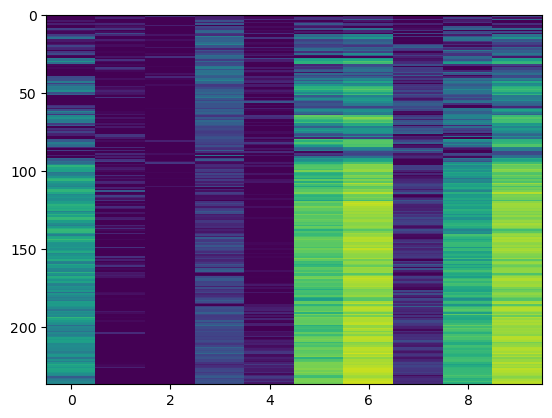

In [263]:
plt.imshow(CCM.PairwiseCCM().compute(np.transpose(unmixed,axes=(1,0,2)),X.T[:,:,None],500,500,5,5,method="smap",theta=5,).mean(axis=0),vmin=0,vmax=1,aspect="auto",interpolation="nearest")

In [264]:
fig = px.line_3d(x=unmixed[:,9,0], y=unmixed[:,9,1],z=unmixed[:,9,2],height=700)

fig.show()